In [1]:
!pip install baseflow

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import baseflow

Q, date = baseflow.load_streamflow("Z:\LWI2023-24\BaseFlow_Separation\Baseflow_Test\example.csv")
b, KGEs = baseflow.separation(Q, date, area=276)
print(f'Best Method: {b.dtype.names[KGEs.argmax()]}')

Best Method: Boughton


In [3]:
import pandas as pd

# Read the CSV file directly into a DataFrame
df = pd.read_csv("Z:\LWI2023-24\BaseFlow_Separation\Baseflow_Test\example.csv", parse_dates=[0])

# Split the DataFrame into 'Q', 'date' and save the separated baseflow data with dates
Q = df.iloc[:, 1]
date = df.iloc[:, 0]
b, KGEs = baseflow.separation(Q, date, area=276)
baseflow_data = pd.DataFrame(b, index=date)
baseflow_data.to_csv('separated_baseflow.csv')


# Assuming method_names is a list of method names in the order corresponding to KGEs
method_names = b.dtype.names

# Saving Kling-Gupta Efficiency scores 'KGEs' with method names
KGEs_data = pd.DataFrame({'Method': method_names, 'KGEs': KGEs})
KGEs_data.to_csv('KGEs.csv', index=False)

In [4]:
import pandas as pd
import baseflow

# Read the CSV file directly into a DataFrame
df = pd.read_csv("Z:\LWI2023-24\BaseFlow_Separation\Baseflow_Test\example2.csv", parse_dates=[0])

# Split the DataFrame into 'Q', 'date'
Q1 = df.iloc[:, 1]
Q2 = df.iloc[:, 2]
date = df.iloc[:, 0]

# Perform baseflow separation for the first column
b1, KGEs1 = baseflow.separation(Q1, date, area=276)

# Perform baseflow separation for the second column
b2, KGEs2 = baseflow.separation(Q2, date, area=276)

# Prepare data for saving
baseflow_data1 = pd.DataFrame(b1, index=date)
baseflow_data2 = pd.DataFrame(b2, index=date)
KGEs_data1 = pd.DataFrame({'Method': b1.dtype.names, 'KGEs': KGEs1})
KGEs_data2 = pd.DataFrame({'Method': b2.dtype.names, 'KGEs': KGEs2})

# Get the column headers for sheet names
sheet_name1, sheet_name2 = df.columns[1], df.columns[2]

# Save data to Excel files with different sheets
with pd.ExcelWriter('separated_baseflowTest2.xlsx') as writer:
    baseflow_data1.to_excel(writer, sheet_name=sheet_name1)
    baseflow_data2.to_excel(writer, sheet_name=sheet_name2)

with pd.ExcelWriter('KGEsTest2.xlsx') as writer:
    KGEs_data1.to_excel(writer, sheet_name=sheet_name1)
    KGEs_data2.to_excel(writer, sheet_name=sheet_name2)

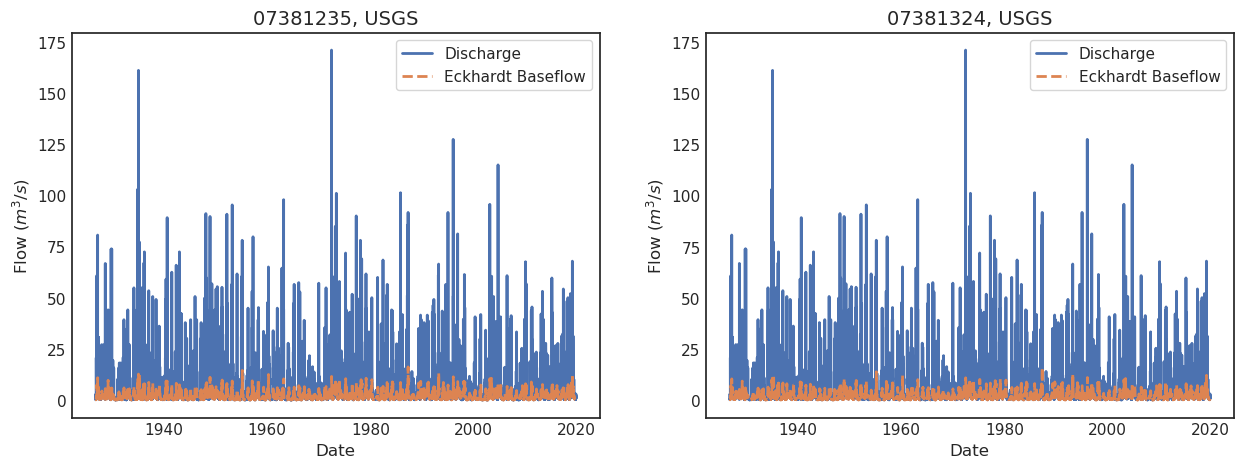

In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


# Set style for better aesthetics
sns.set(style="white")

# Create subplots with 2 columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Data for plotting
data = [(Q1, baseflow_data1, sheet_name1, axs[0]), (Q2, baseflow_data2, sheet_name2, axs[1])]

for Q, baseflow_data, sheet_name, ax in data:
    ax.plot(date, Q, label='Discharge', linewidth=2)
    ax.plot(date, baseflow_data['Eckhardt'], label='Eckhardt Baseflow', linestyle='--', linewidth=2)
    ax.set_title(sheet_name, fontsize=14)
    ax.tick_params(axis='both', which='both', direction='in')
    ax.legend()
    ax.set_ylabel('Flow ($m^3/s$)')
    ax.set_xlabel('Date')

plt.style.use('default')
plt.show()

In [6]:
import csv
import dataretrieval.nwis as nwis
import math

# List of gage numbers
gage_numbers = [
    "07374525", "295501090190400", "07380401", "07381590", "07381670", "07385765", "07385700",
    "07378500", "07376000", "07376500", "07375500", "07378000", "02492000", "07374000", "07381490",
    "07381482", "07375000", "07375960", "02489500", "07377500", "07377000", "07375800", "07386980",
    "08012000", "08015500", "08014500", "08014800", "08010000", "08013500", "07382500", "08013000",
    "07382000", "07383500", "08028000", "08025500", "08023400", "08023080", "07373000", "07372200"
]

# Define the output CSV files
output_file = "drainage_areas.csv"
nan_gages_file = "gages_with_nan.csv"
valid_gages_file = "valid_gages.csv"

gages_with_nan = []
valid_gages = []

# Open the CSV file in write mode
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(["Gage", "Area_sqmile", "Area_sqkm"])
    
    # Loop over each gage number and fetch the drainage area
    for gage_number in gage_numbers:
        formatted_gage = f"{gage_number}, USGS"
        
        try:
            # Get the site information
            site_info = nwis.get_record(sites=gage_number, service='site')
            
            # Extract the drainage area value
            drainage_area_sqmile = float(site_info.iloc[0]['drain_area_va'])
            
            # Check if the drainage area is NaN
            if math.isnan(drainage_area_sqmile):
                gages_with_nan.append(formatted_gage)
                print(f"Found NaN value for site {gage_number}. Skipping...")
                continue
            
            # Convert square mile to square km
            drainage_area_sqkm = drainage_area_sqmile * 2.58999
            
            # Write the data row to the CSV file
            writer.writerow([formatted_gage, drainage_area_sqmile, drainage_area_sqkm])
            
            # Add the gage to the valid gages list
            valid_gages.append(formatted_gage)
            
            print(f"Saved data for site {gage_number}: {drainage_area_sqmile} square miles, {drainage_area_sqkm} square km")
        except Exception as e:
            print(f"Failed to retrieve data for site {gage_number}: {e}")

print(f"Data written to {output_file}.")

# Save the gages with NaN values to a separate CSV
with open(nan_gages_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Gage"])
    for gage in gages_with_nan:
        writer.writerow([gage])

print(f"Gages with NaN values written to {nan_gages_file}.")

# Save the valid gages to a separate CSV
with open(valid_gages_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Gage"])
    for gage in valid_gages:
        writer.writerow([gage])

print(f"Valid gages written to {valid_gages_file}.")

Saved data for site 07374525: 1130000.0 square miles, 2926688.6999999997 square km
Found NaN value for site 295501090190400. Skipping...
Found NaN value for site 07380401. Skipping...
Found NaN value for site 07381590. Skipping...
Found NaN value for site 07381670. Skipping...
Found NaN value for site 07385765. Skipping...
Found NaN value for site 07385700. Skipping...
Saved data for site 07378500: 1280.0 square miles, 3315.1872 square km
Saved data for site 07376000: 247.0 square miles, 639.72753 square km
Saved data for site 07376500: 79.5 square miles, 205.904205 square km
Saved data for site 07375500: 646.0 square miles, 1673.1335399999998 square km
Saved data for site 07378000: 284.0 square miles, 735.55716 square km
Saved data for site 02492000: 1213.0 square miles, 3141.6578699999995 square km
Saved data for site 07374000: 1125810.0 square miles, 2915836.6418999997 square km
Saved data for site 07381490: 87570.0 square miles, 226805.42429999998 square km
Found NaN value for site

In [8]:
import csv
import pandas as pd

# Define the input and output file names
input_file = "LA_Discharges_noTidal.csv"
output_file = "LA_Discharges_noTidal_SI.csv"
valid_gages_file = "valid_gages.csv"

# Conversion factor from ft^3/s to m^3/s
conversion_factor = 0.0283168

# Create lists to store the header and data
header = []
data = []

# Read the valid gages from the CSV generated by Code 2
with open(valid_gages_file, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # skip header
    valid_gages = [row[0] for row in reader]

# Read the input file
with open(input_file, mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        data.append(row)

header = data[0]
data = data[1:]

# Filter out columns that aren't in valid_gages
col_indices_to_keep = [0] + [index for index, col in enumerate(header) if col in valid_gages]
header = [header[i] for i in col_indices_to_keep]
filtered_data = [[row[i] for i in col_indices_to_keep] for row in data]

# Convert the discharge data
converted_data = []
for row in filtered_data:
    new_row = [row[0]]  # Preserving the datetime
    for value in row[1:]:
        if value:  # Check if the value is not empty
            new_row.append(str(float(value) * conversion_factor))
        else:
            new_row.append('')
    converted_data.append(new_row)

# Write the converted data to the output file
with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Write the header row
    for row in converted_data:
        writer.writerow(row)

print(f"Data converted and written to {output_file}.")

Data converted and written to LA_Discharges_noTidal_SI.csv.


In [10]:
import pandas as pd
import baseflow

# Read the CSV file directly into a DataFrame
df = pd.read_csv("Z:\\LWI2023-24\\BaseFlow_Separation\\Baseflow_Test\\LA_Discharges_noTidal_SI.csv", parse_dates=[0])
date = df.iloc[:, 0]

# Load drainage area data
area_df = pd.read_csv("drainage_areas.csv")

# Initialize Excel writers
with pd.ExcelWriter('separated_baseflow_LA_SI.xlsx') as baseflow_writer, pd.ExcelWriter('KGEs_LA.xlsx') as KGEs_writer:
    # Loop through each discharge column and perform baseflow separation
    for col in df.columns[1:]:
        # Extract the gage number from the column name
        gage_number = col.split(",")[0].strip()
        
        # Get the area for the current gage
        area = area_df.loc[area_df['Gage'].str.startswith(gage_number), 'Area_sqkm'].values[0]
        
        # Perform baseflow separation with the retrieved area
        Q = df[col]
        b, KGEs = baseflow.separation(Q, date, area=area)
        
        # Prepare data for saving
        baseflow_data = pd.DataFrame(b, index=date)
        KGEs_data = pd.DataFrame({'Method': b.dtype.names, 'KGEs': KGEs})
        
        # Save data to Excel files with different sheets
        baseflow_data.to_excel(baseflow_writer, sheet_name=col)
        KGEs_data.to_excel(KGEs_writer, sheet_name=col)

In [11]:
import pandas as pd

# Conversion factor from m^3/s to ft^3/s
conversion_factor = 35.315

# Convert and save the 'separated_baseflow_LA_SI.xlsx' file
xls_file = pd.ExcelFile("separated_baseflow_LA_SI.xlsx")
with pd.ExcelWriter("separated_baseflow_LA_ft3s.xlsx") as writer:
    for sheet_name in xls_file.sheet_names:
        df = xls_file.parse(sheet_name)
        # Convert columns containing discharge values
        for col in df.columns:
            if df[col].dtype == 'float64':
                df[col] = df[col] * conversion_factor
        df.to_excel(writer, sheet_name=sheet_name, index=False)

# Convert and save the 'LA_Discharges_noTidal_SI.csv' file
csv_file = pd.read_csv("LA_Discharges_noTidal_SI.csv")
for col in csv_file.columns:
    if csv_file[col].dtype == 'float64':
        csv_file[col] = csv_file[col] * conversion_factor
csv_file.to_csv("LA_Discharges_noTidal_ft3s.csv", index=False)

print("Conversion completed and files saved.")

Conversion completed and files saved.


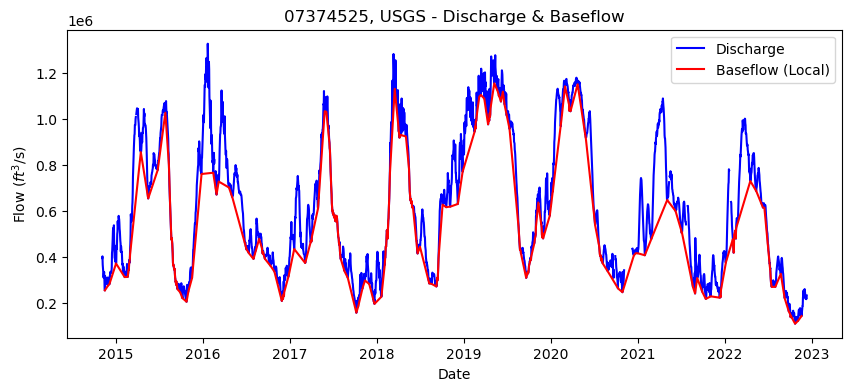

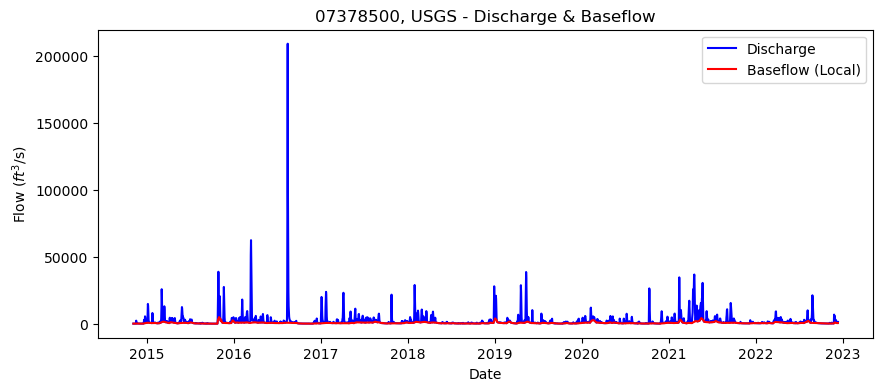

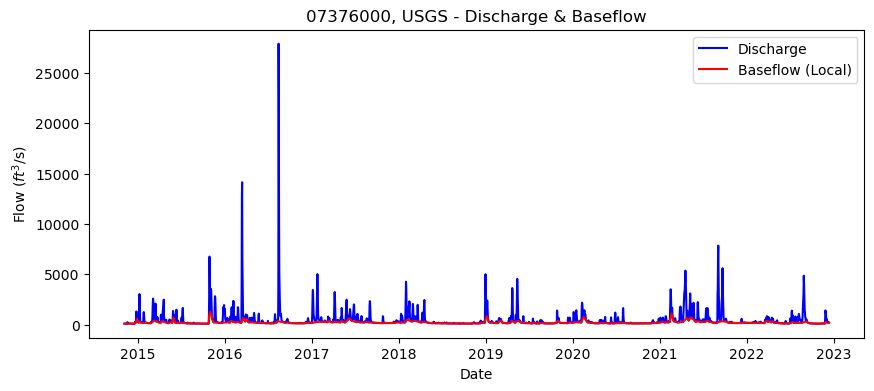

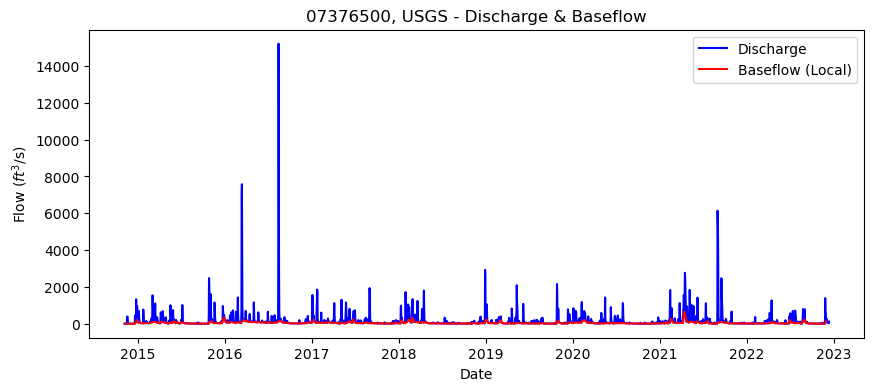

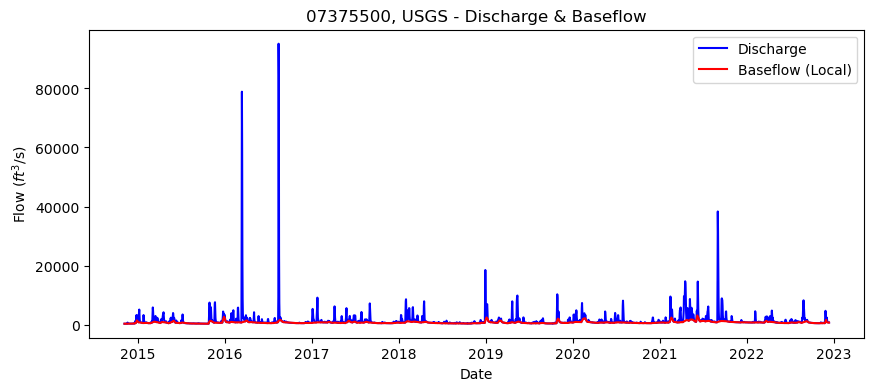

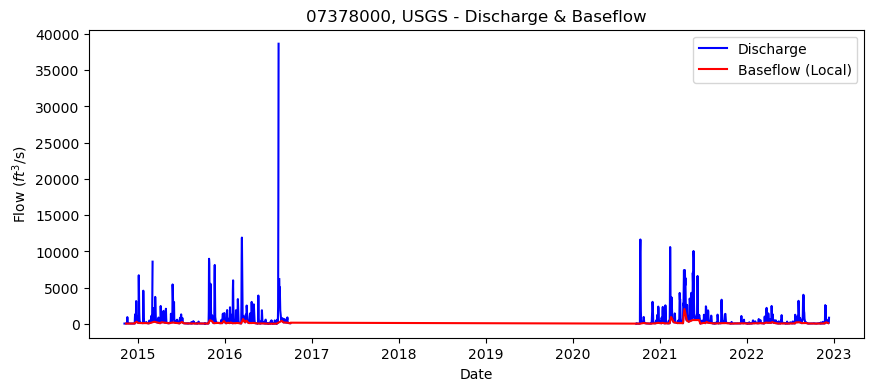

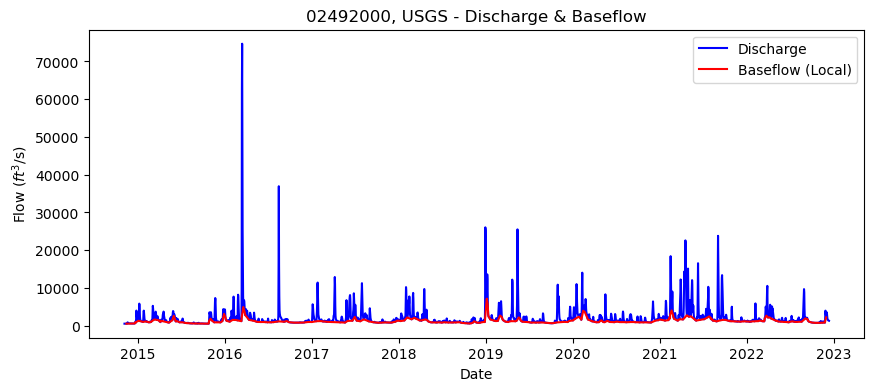

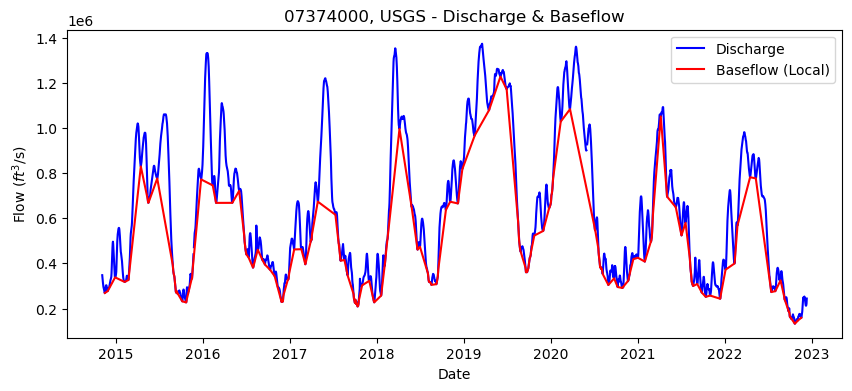

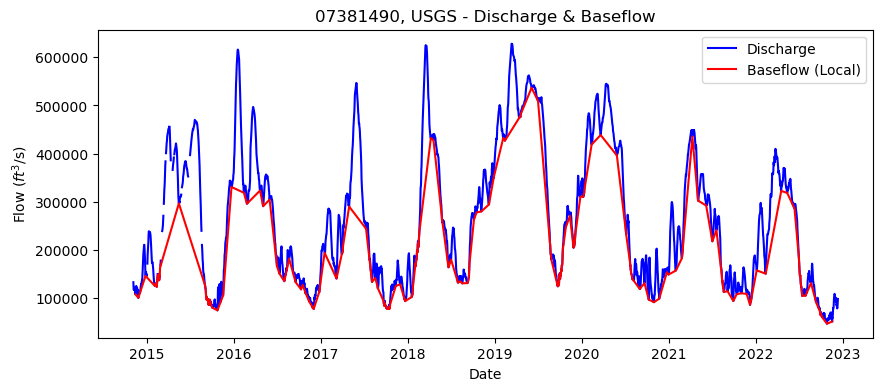

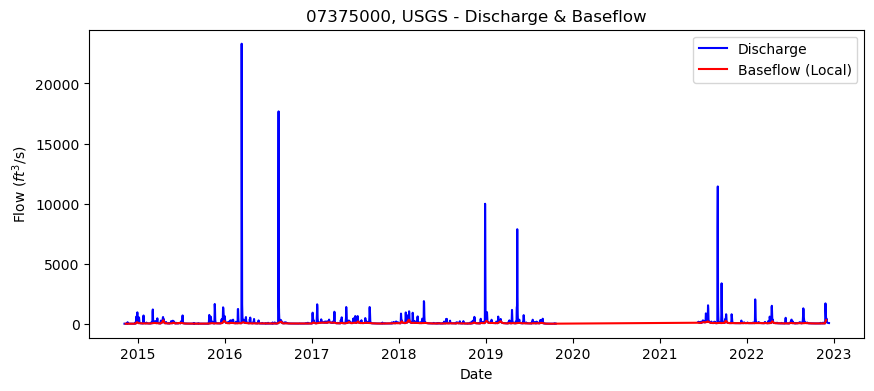

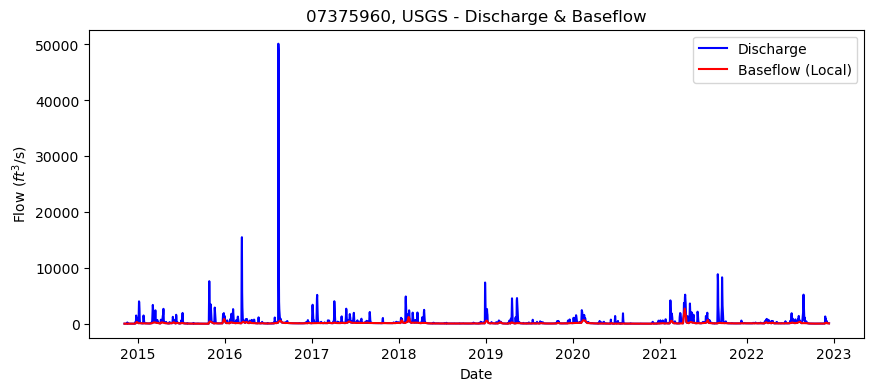

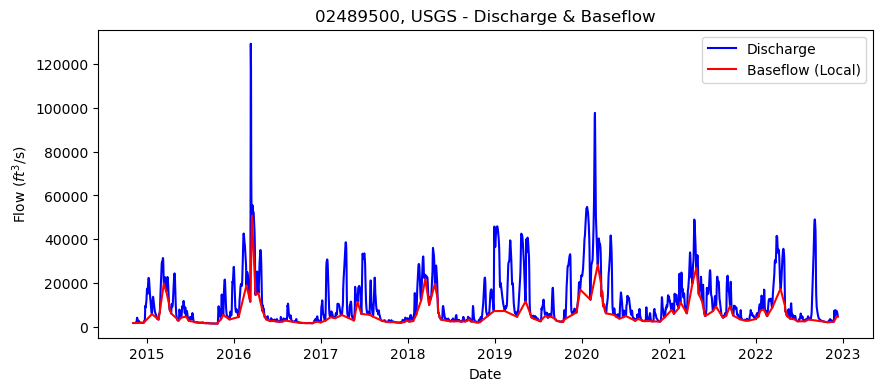

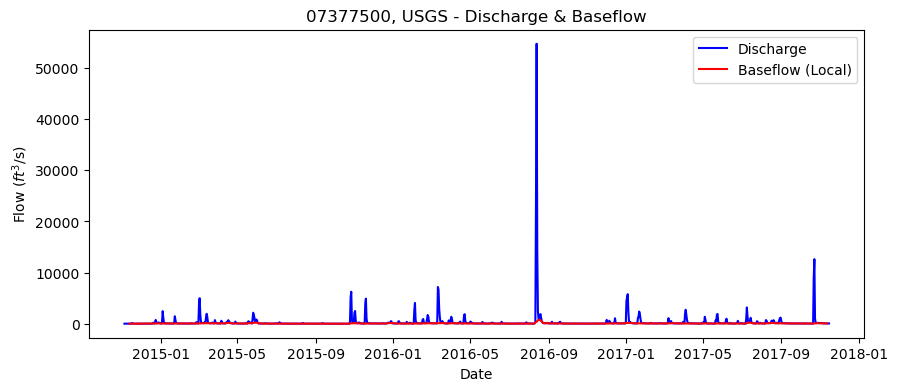

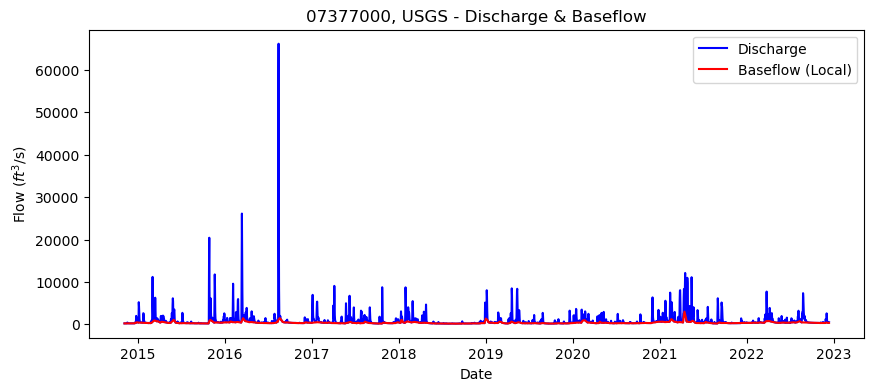

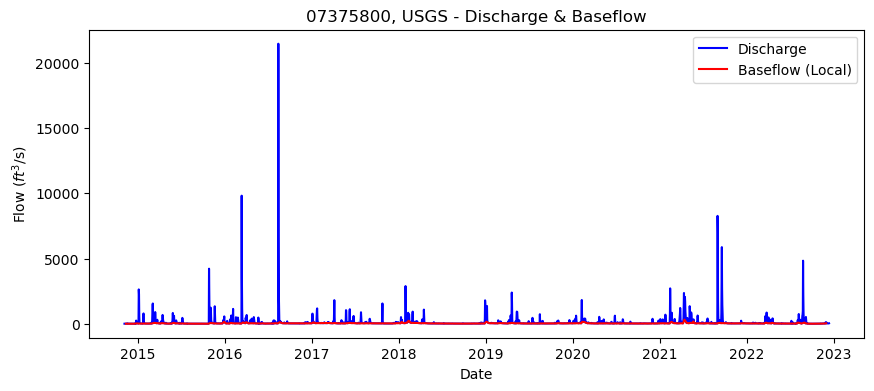

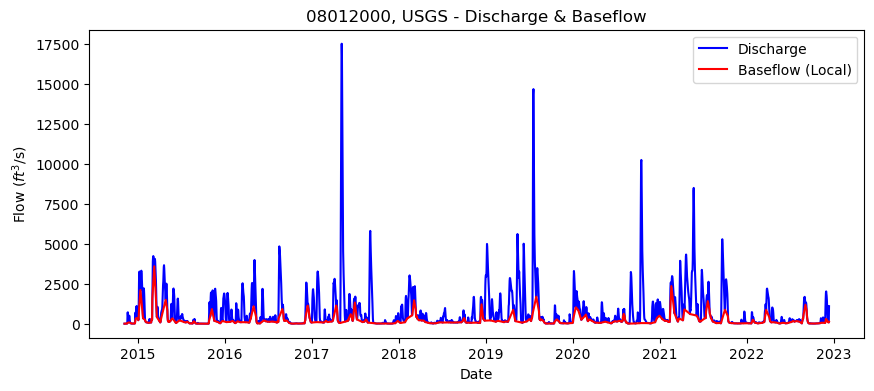

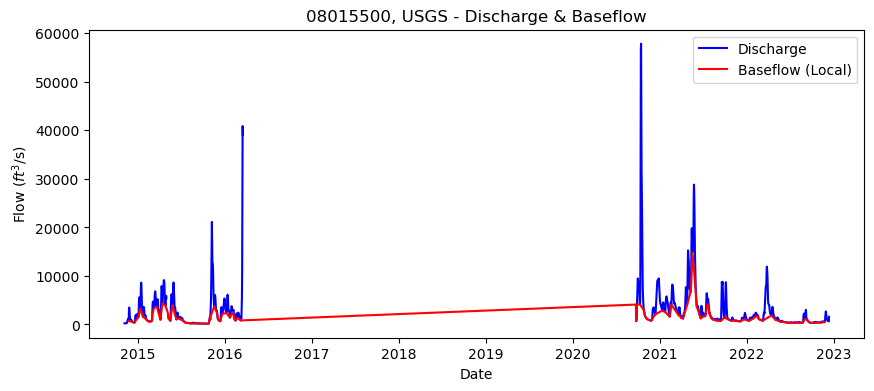

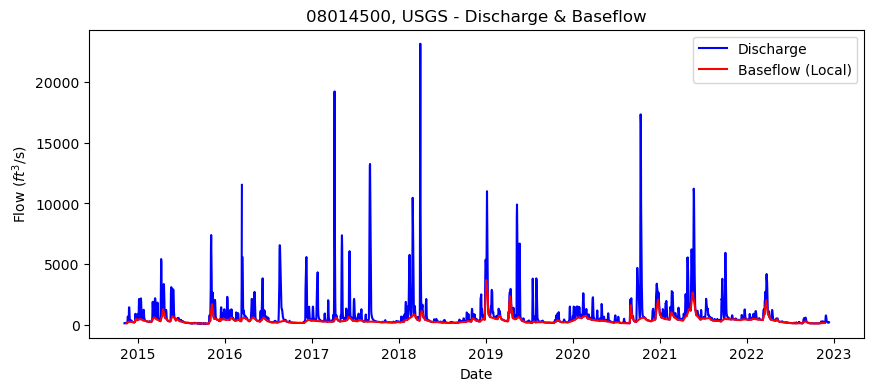

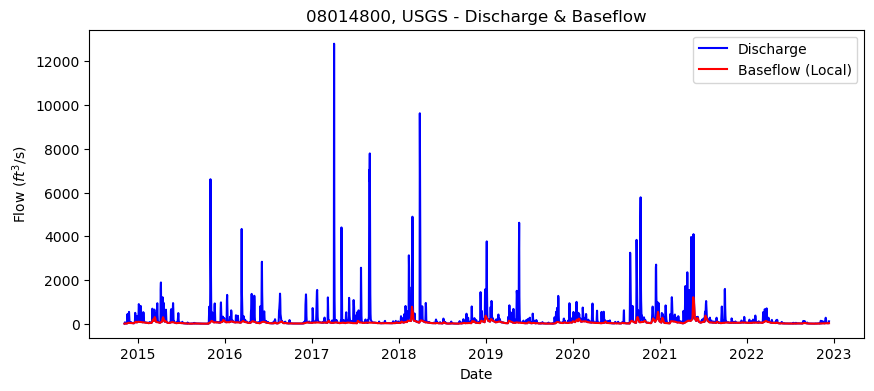

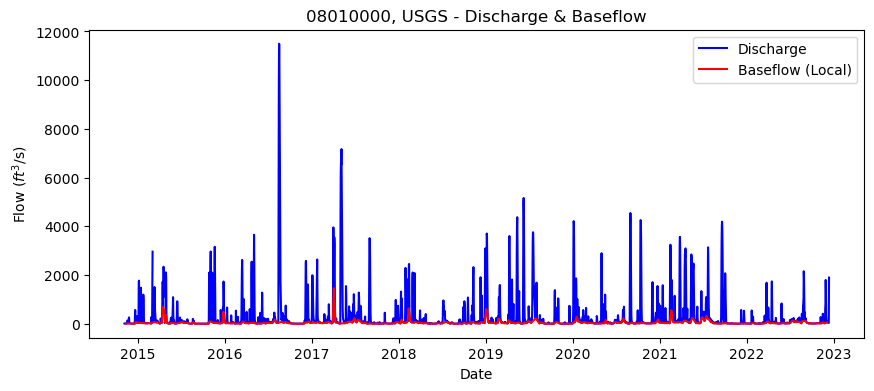

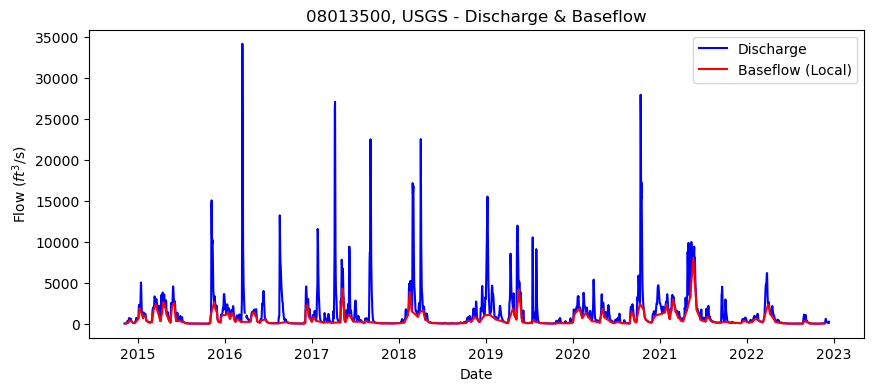

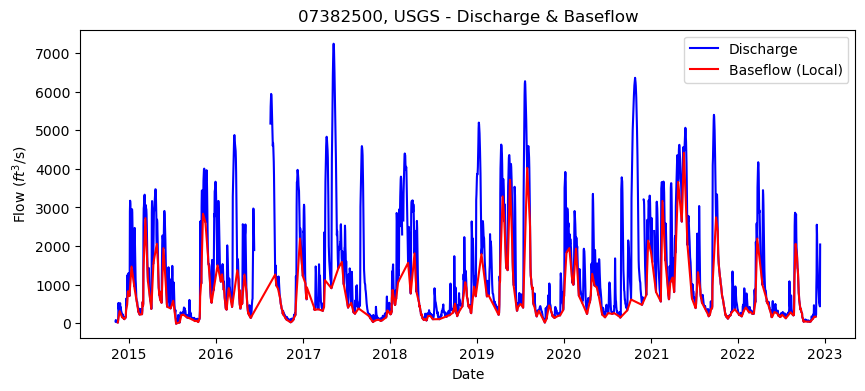

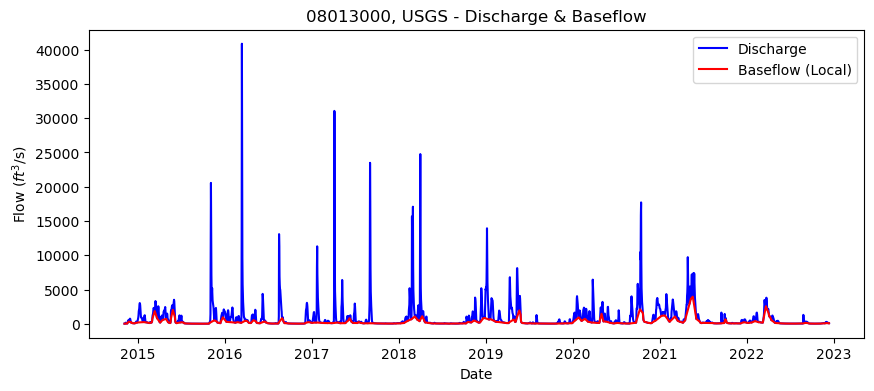

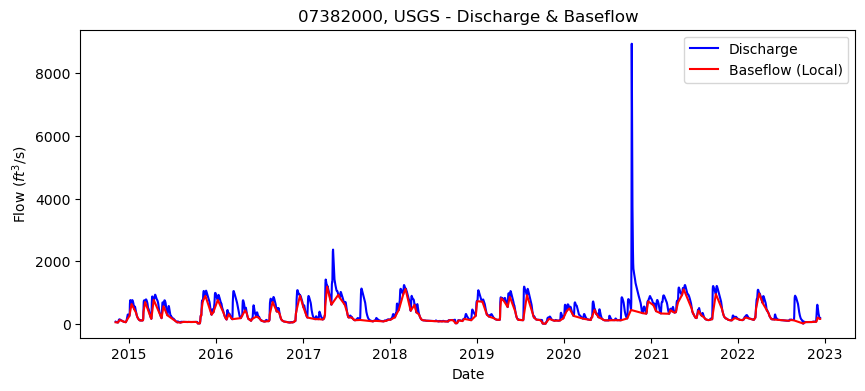

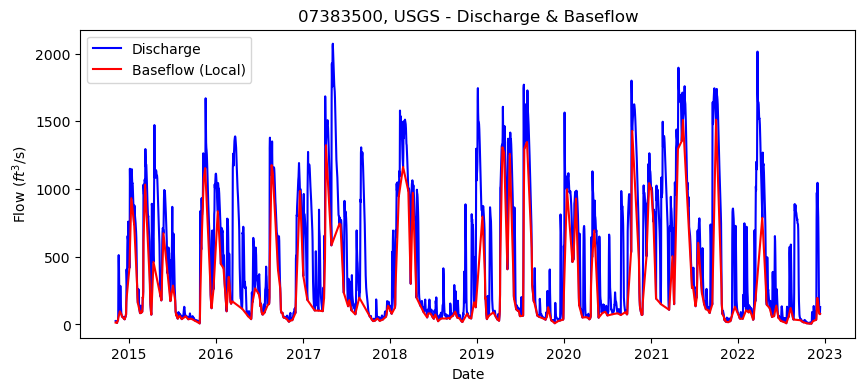

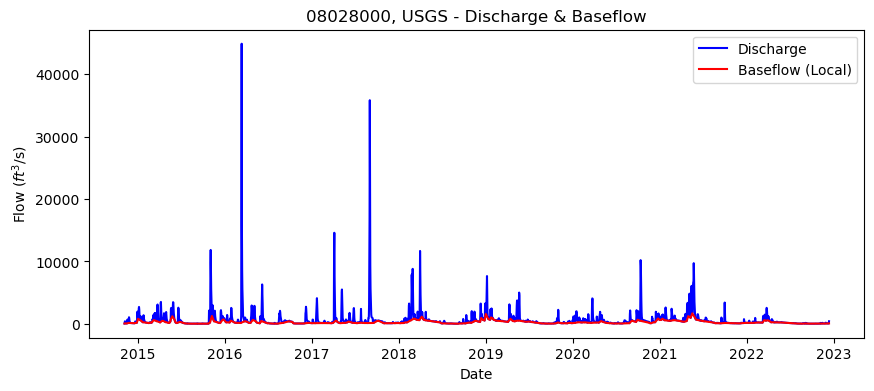

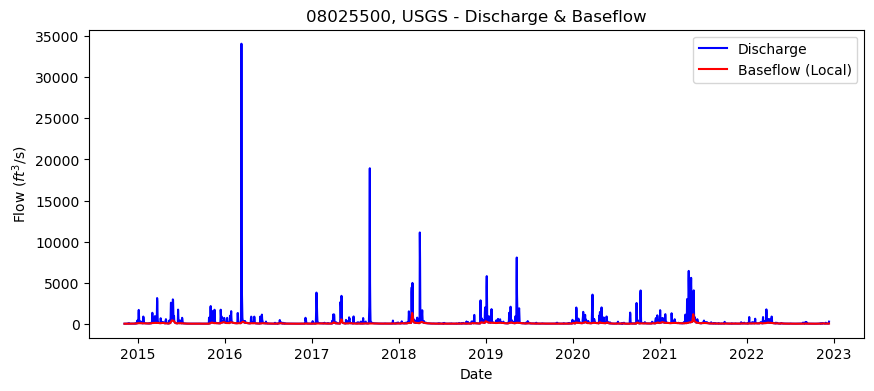

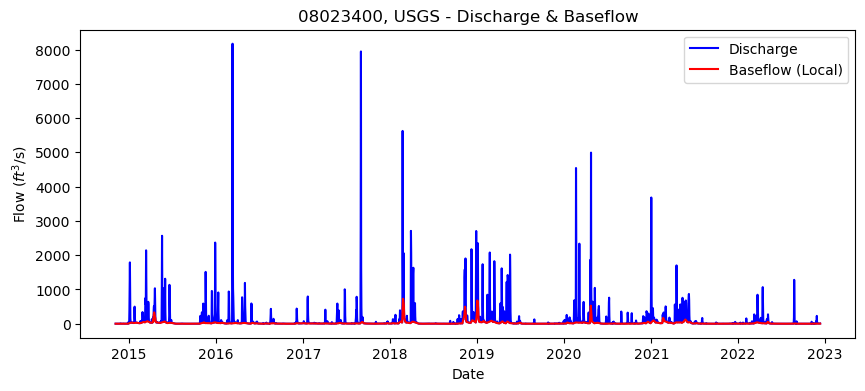

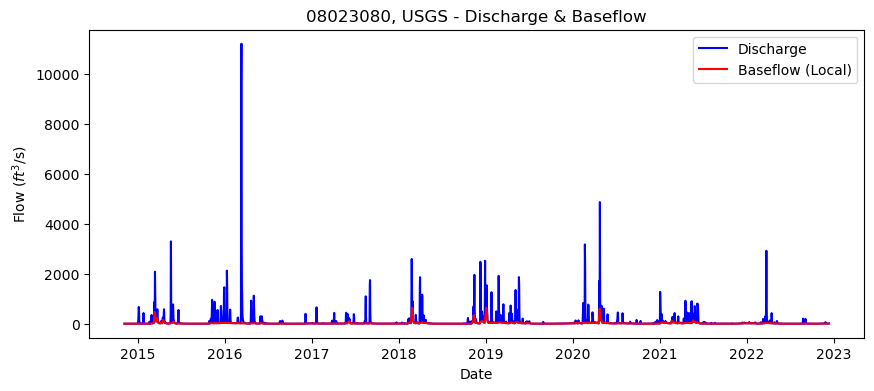

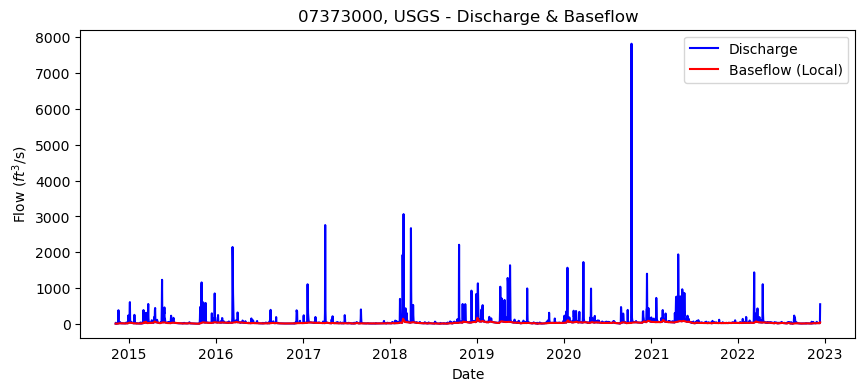

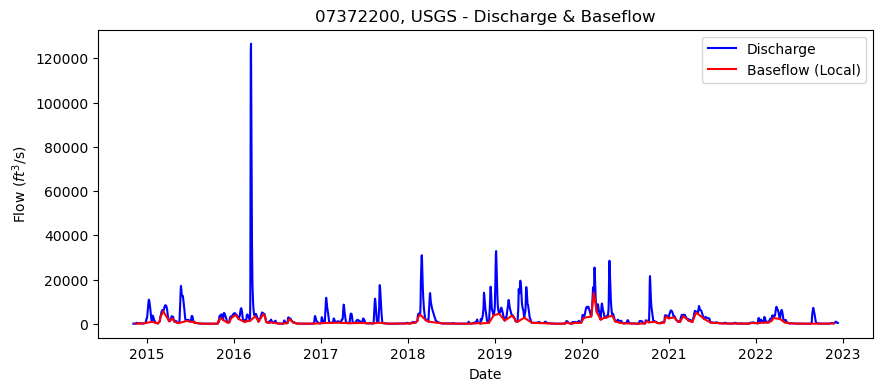

All plots saved in 'Discharge_and_Basflow_Plots_LA' directory.


In [12]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load data from the specified files
baseflow_file = pd.ExcelFile("separated_baseflow_LA_ft3s.xlsx")
discharge_df = pd.read_csv("LA_Discharges_noTidal_ft3s.csv")

# Extract date for x-axis
dates = pd.to_datetime(discharge_df.iloc[:, 0])

# Number of gages (columns minus the date column)
num_gages = len(discharge_df.columns) - 1

# Create a directory to save the plots
save_dir = "Discharge_and_Basflow_Plots_LA"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for idx, col in enumerate(discharge_df.columns[1:]):
    # Create a new figure for each plot
    fig, ax = plt.subplots(figsize=(10, 4))

    # Extract the discharge series from the CSV and the baseflow series from the Excel
    discharge_series = discharge_df[col]
    baseflow_df = baseflow_file.parse(col)
    baseflow_series = baseflow_df['Local']
    
    # Plotting Discharge and Baseflow on the same plot
    ax.plot(dates, discharge_series, label='Discharge', color='blue')
    ax.plot(dates, baseflow_series, label='Baseflow (Local)', color='red')

    ax.set_title(f"{col} - Discharge & Baseflow")
    ax.set_xlabel('Date')
    ax.set_ylabel('Flow ($ft^3$/s)')
    ax.legend()
    
    # Show the plot
    plt.show()
    
    # Save the plot as an image in the specified directory
    save_path = os.path.join(save_dir, f"{col}_Discharge_Baseflow.png")
    fig.savefig(save_path)
    plt.close(fig)  # Close the plot

print(f"All plots saved in '{save_dir}' directory.")